## LAB 4

*This R script is partially based on the 'LAB 3: Clusters, Factions and Cores' 
script from the Social Network Analysis course at Stanford  University
(available at: https://sna.stanford.edu/lab.php?l=3)
*

The purpose of this lab is to introduce different 
community detection (clustering) methods that allow 
for identifying communities (groups, clusters) in a 
social network.

### 1. SET UP A SESSION

#### 1.1 Load the required R packages

For this lab, in addition to igraph, we'll use four new R packages:
- cluster: a package for general purpose cluster-analysis with  
  applications beyond the social-network context
- factoextra: a package for seamless visualisation of clustering results
  (and many other things)
- proxy: we'll use it to compute cosine similarity - a similarity measure 
  required in the clustering process
- animation: used, not surprisingly, for producing animations
- NetData: a package with all datasets used in the Stanford's SNA R labs

To see what datasets are available in the package, check:
  https://cran.r-project.org/web/packages/NetData/NetData.pdf

Reminder: installation of packages is to be done just once; 
loading of packages has to be done in every session they are to be used

In [15]:
#install.packages('proxy')

# This didn't work for me, so I installed the package using the second code line
# install.packages("animation", 
#                  repos = "http://cran.cnr.berkeley.edu/",
#                  dependencies = TRUE)

#install.packages('animation')

#install.packages(c('cluster', 'proxy', 'NetData', 'factoextra'))

#install.packages('NetData')

In [16]:
library(igraph)
library(cluster)
library(proxy)
library(animation)
library(NetData)

#### 1.2 Set the seed to be used in random processes

In [17]:
seed <- 612

### 2. LOADING the DATA and CREATING GRAPHS

We'll use a dataset from the NetData package:

In [18]:
data(studentnets.M182, package = "NetData")

Out of the 4 loaded data frames (df), we will use 3 dfs 
with data about 3 student networks:
- friend_df: self-reported friendship ties
  (2 = best friend, 1 = friend, 0 = not friend)
- social_df: observed social interactions
- task_df: observed task interactions

Note that all 3 networks represent the same 
group of students, related via 3 different kinds 
of relationships

In [19]:
str(friend_df)
table(friend_df$friend_tie)

'data.frame':	256 obs. of  3 variables:
 $ ego       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ alter     : int  1 2 3 4 5 6 7 8 9 10 ...
 $ friend_tie: num  0 0 0 0 0 0 0 0 0 0 ...



  0   1   2 
194  54   8 

All three dfs have the same structure:
- the first column is the ego, 
- the second column is the alter, 
- the third column is an integer or a floating-point number
  greater than or equal to zero representing the strength 
  of the association for the given two vertices (ego, alter).

There is also the 4th df - m182_full_data_frame - that
integrates data for the 3 abovementioned networks. 

In [20]:
str(m182_full_data_frame)

'data.frame':	256 obs. of  5 variables:
 $ ego       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ alter     : int  1 2 3 4 5 6 7 8 9 10 ...
 $ friend_tie: num  0 0 0 0 0 0 0 0 0 0 ...
 $ social_tie: num  0 0 0 0 1.2 0 0 0.15 2.85 6.45 ...
 $ task_tie  : num  0 0 0 0 0.3 0 0 0 0.3 0.3 ...


As we won't need it for this lab, we'll remove it:

In [21]:
remove(m182_full_data_frame)

Create graphs for the 3 different types of ties

In [22]:
#View(head(friend_df, 20))
head(friend_df, 20)

,ego,alter,friend_tie
,<int>,<int>,<dbl>
1,1,1,0
2,1,2,0
3,1,3,0
4,1,4,0
5,1,5,0
6,1,6,0
7,1,7,0
8,1,8,0
9,1,9,0


Notice many zeros (at least half tie values are zero); 
so, we'll first select only those rows of the df 
where ego and alter are connected through friend tie.
If we do not do this, we would get a graph where all node 
pairs would be connected and we would have to rely on the 
connection (edge) weight to determine if a connection exists
or not (0 - not connected, >0 - connected)

In [23]:
friend_net_nonzero_edges <- subset(friend_df, friend_tie > 0)

Now, create a network

In [24]:
friend_net <- graph_from_data_frame(friend_net_nonzero_edges)
summary(friend_net)
V(friend_net)$name

IGRAPH 5878eb8 DN-- 14 62 -- 
+ attr: name (v/c), friend_tie (e/n)


[1] "2"  "3"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15" "1"

Note that 2 nodes are missing (4 and 16) - that is because
those students didn't report friendship tie with any other student

Do the same for the other two dfs

In [25]:
#View(head(social_df, 20))
head(social_df, 20)

,ego,alter,social_tie
,<int>,<int>,<dbl>
1,1,1,0.00
2,1,2,0.00
3,1,3,0.00
4,1,4,0.00
5,1,5,1.20
6,1,6,0.00
7,1,7,0.00
8,1,8,0.15
9,1,9,2.85


Note: the weight in this network is the estimated number of 
social interactions per hour.

In [26]:
social_net <- graph_from_data_frame(subset(social_df, social_tie > 0))
summary(social_net)
V(social_net)$name # all students present

IGRAPH 5ce2a10 DN-- 16 129 -- 
+ attr: name (v/c), social_tie (e/n)


[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16"

In [27]:
#View(head(task_df, 20))
head(task_df, 20)

,ego,alter,task_tie
,<int>,<int>,<dbl>
1,1,1,0.00
2,1,2,0.00
3,1,3,0.00
4,1,4,0.00
5,1,5,0.30
6,1,6,0.00
7,1,7,0.00
8,1,8,0.00
9,1,9,0.30


Note: the weight in this network is the estimated number of 
task-related interactions per hour.

In [28]:
task_net <- graph_from_data_frame(subset(task_df, task_tie > 0))
summary(task_net)
V(task_net)$name # all students present

IGRAPH 5e47c0f DN-- 16 88 -- 
+ attr: name (v/c), task_tie (e/n)


[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16"

To get an idea of what the three student networks look like, 
let's create a function that will allow us to quickly plot graphs.
The edge_weights argument will allow us to plot edge thickness 
proportional to the intensity of the ties between actor pairs

In [29]:
plot_graph <- function(g, connection_type, edge_weights) {
  set.seed(seed)
  plot(g, 
       layout=layout_with_kk(g),
       vertex.color='gold', 
       vertex.frame.color='steelblue4',
       edge.arrow.size=.3,
       #edge.arrow.size=.4*edge_weights,#when weights are very different, fixed arrow size will sometimes hide arrow, so this can fix that by making the arrow size related to the link width
       edge.width=edge_weights,
       edge.color='steelblue3', 
       main=paste(connection_type, "network"))
}

Use the function to plot the friendship network

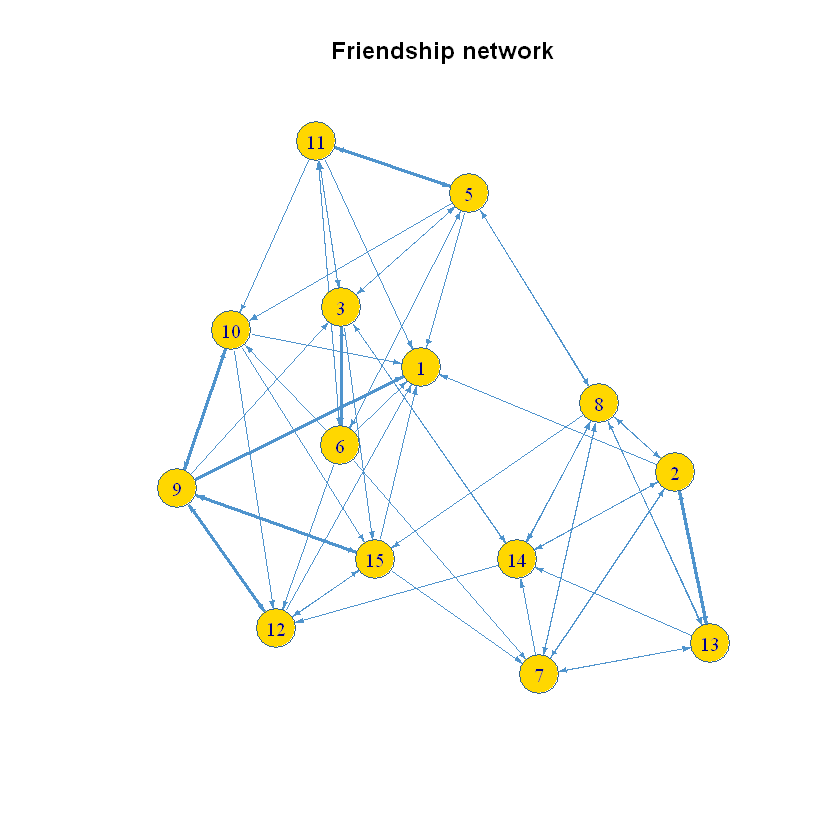

In [30]:
friend_tie_weights <- E(friend_net)$friend_tie * 1.35
plot_graph(friend_net, 'Friendship', friend_tie_weights)

Now, plot the social interactions network

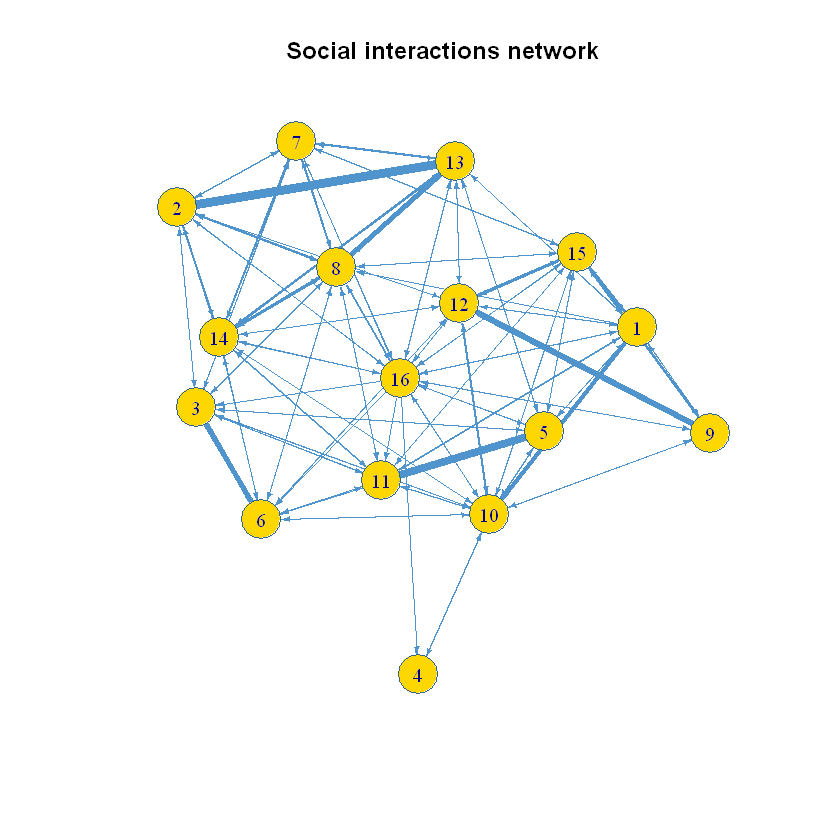

In [31]:
plot_graph(social_net, 'Social interactions', 
           E(social_net)$social_tie * 0.5)

And, the task interactions network

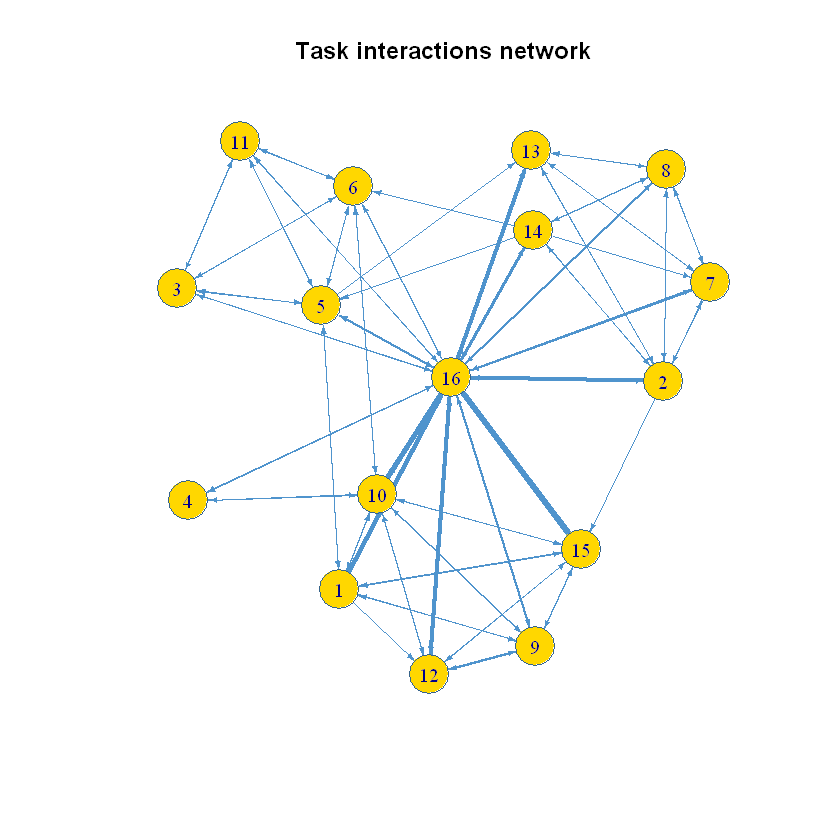

In [32]:
plot_graph(task_net, 'Task interactions', 
           E(task_net)$task_tie * 0.75)

If curious about the weights of the thick edges, you can inspect
those weights, for example, by viewing adjacency matrix

In [33]:
as_adjacency_matrix(task_net, attr = "task_tie")

   [[ suppressing 16 column names '1', '2', '3' ... ]]



16 x 16 sparse Matrix of class "dgCMatrix"
                                                                            
1  .    .    .    .    0.30 .    .    .    0.30 0.30 .   0.15 .    .    0.15
2  .    .    .    .    .    .    0.75 0.30 .    .    .   .    0.90 0.15 0.15
3  .    .    .    .    0.15 0.60 .    .    .    .    0.3 .    .    .    .   
4  .    .    .    .    .    .    .    .    .    0.15 .   .    .    .    .   
5  0.30 .    0.15 .    .    0.75 .    .    .    .    2.1 .    0.15 .    .   
6  .    .    0.75 .    0.45 .    .    .    .    0.15 0.3 .    .    .    .   
7  .    1.20 .    .    .    .    .    0.15 .    .    .   .    0.30 .    .   
8  .    0.45 .    .    .    .    0.30 .    .    .    .   .    0.75 0.15 .   
9  0.15 .    .    .    .    .    .    .    .    0.30 .   2.70 .    .    0.15
10 0.15 .    .    0.15 .    0.30 .    .    0.45 .    .   0.75 .    .    0.30
11 .    .    0.15 .    1.80 0.45 .    .    .    .    .   .    .    .    .   
12 .    .    .    .    .    .    

### 3. COMMUNITY DETECTION

We'll use the friend network as the basis for our exploration of 
community detection methods. For clarity and simplicity, we'll 
set the network to undirected and assure it is connected. 
Note: a large portion of the current community detection algorithms
work only with undirected graphs.

In [34]:
friend_net_und <- as.undirected(friend_net, 
                                 mode='collapse',
                                 edge.attr.comb="max")
summary(friend_net_und)

IGRAPH 65f528d UN-- 14 42 -- 
+ attr: name (v/c), friend_tie (e/n)


Note that the number of edges has decreased (62->42) as reciprocated 
directed ties were consolidated into single undirected ties. We can check
also tie weights:

In [35]:
table(E(friend_net_und)$friend_tie)


 1  2 
35  7 

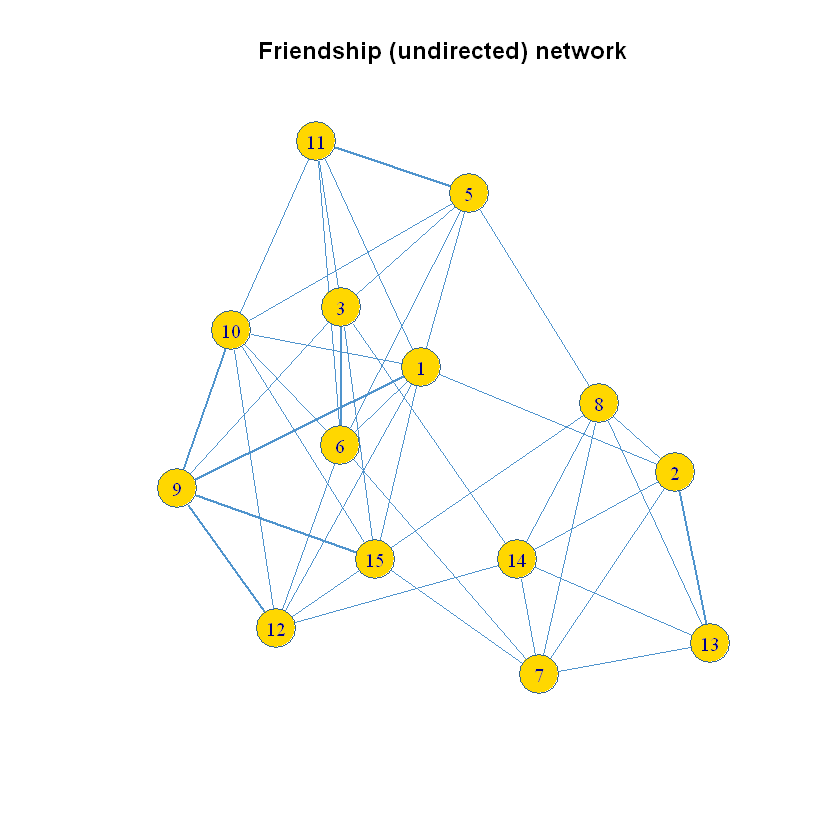

In [36]:
plot_graph(friend_net_und, 
           'Friendship (undirected)', 
           E(friend_net_und)$friend_tie)

Check if it is connected 

In [37]:
is_connected(friend_net_und)

[1] TRUE

it is connected

There are many different ways to detect communities in a network. 
A common characteristic of a large majority, if not all, of them
is their reliance on a measure called Modularity to estimate the
quality of the detected community structure.
Modularity measures the strength of division of a network into 
modules (clusters, communities). More precisely, it measures the
density of links inside communities as compared to the density of 
links between communities. It takes values between -1 and 1.
Networks with high modularity have dense connections between the 
nodes within modules (communities) but sparse connections between 
nodes in different modules.

Note: for more details about the modularity measure, listen / watch
the explanation of modularity given in the (video) lecture: 
Network Analysis. Lecture 8. Network communities:
https://www.youtube.com/watch?v=lU1QEUH0nNc around 1h 5min 

In this lab, we'll examine the following algorithms for 
community detection: 
- Edge-betweenness
- Louvain (Multi-level optimization of modularity)
- Walktrap
- General clustering

and compare their performance using the Modularity metric.

For the sake of quantitative comparison of different community detection
algorithms, we'll keep a list of modularity scores produced by the algorithms:

In [38]:
modularity_scores <- list()

#### 3A. COMMUNITY DETECTION: THE EDGE BETWEENNESS METHOD 

The edge-betweenness (EB) score of an edge measures the proportion of shortest 
paths between any pair of vertices in the graph that go through that edge. 
The EB community detection method is a hierarchical graph decomposition process 
where edges are removed in the decreasing order of their EB scores.
The method is motivated by the assumption that edges connecting different 
communities are more likely to be part of multiple shortest paths, that is, have
high EB score, simply because in many cases they are the only option to go 
from one community to another. 

In [49]:
?cluster_edge_betweenness

In [39]:
friend_comm_eb <- cluster_edge_betweenness(friend_net_und, directed = FALSE)
friend_comm_eb

IGRAPH clustering edge betweenness, groups: 3, mod: 0.28
+ groups:
  $`1`
  [1] "2"  "7"  "8"  "13" "14"
  
  $`2`
  [1] "3"  "5"  "6"  "11"
  
  $`3`
  [1] "9"  "10" "12" "15" "1" 
  

we got 3 groups, with 5, 4, and 5 vertices

We can plot the graph with color coded community membership to better
estimate the partitioning

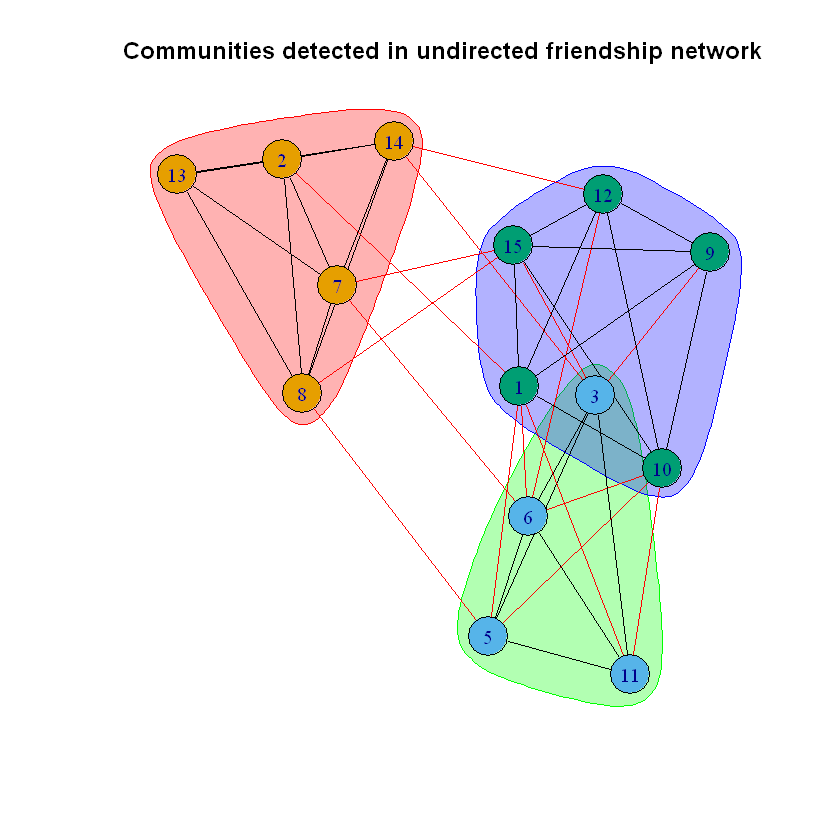

In [40]:
plot(friend_comm_eb,  friend_net_und,
     main="Communities detected in undirected friendship network")

We can also identify edges that connect two different communities; these
are also referred to as bridges.
The ```crossing()``` f. returns a logical vector, with one value for each 
edge, ordered according to the edge ids. The value is TRUE if the 
edge connects two different communities

In [41]:
crossing(friend_comm_eb, friend_net_und)
cross_community_edges <- 
  which(crossing(friend_comm_eb, friend_net_und)==TRUE)
cross_community_edges

3|5   3|6   5|6   2|7   6|7   2|8   5|8   7|8   3|9  5|10  6|10  9|10  3|11 
FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE FALSE FALSE 
 5|11  6|11 10|11  6|12  9|12 10|12  2|13  7|13  8|13  2|14  3|14  7|14  8|14 
FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE 
12|14 13|14  3|15  7|15  8|15  9|15 10|15 12|15   2|1   5|1   6|1   9|1  10|1 
 TRUE FALSE  TRUE  TRUE  TRUE FALSE FALSE FALSE  TRUE  TRUE  TRUE FALSE FALSE 
 11|1  12|1  15|1 
 TRUE FALSE FALSE

6|7   5|8   3|9  5|10  6|10 10|11  6|12  3|14 12|14  3|15  7|15  8|15   2|1 
    5     7     9    10    11    16    17    24    27    29    30    31    35 
  5|1   6|1  11|1 
   36    37    40

We can establish a connection here with the concept of brokers that
we discussed in the context of betweenness centrality: 
brokers are nodes with high betweenness centrality that often 
connect two or more communities.

We can detect brokers by visualizing a network using:
- node size to denote betweenness centrality, 
- node color to mark community membership, and
- edge color to mark cross community edges

In [42]:
edge_color <- rep('steelblue4', times=ecount(friend_net_und))
edge_color[cross_community_edges] <- 'firebrick4'

In [43]:
fnet_betweenness <- betweenness(friend_net_und, directed = FALSE)

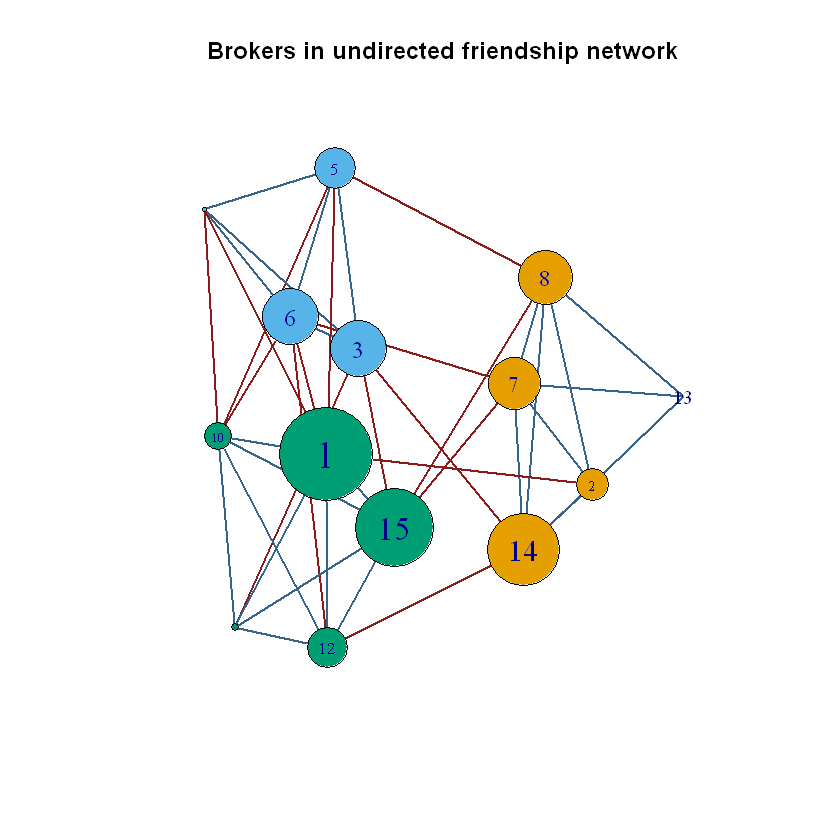

In [44]:
fnet_copy <- friend_net_und
E(fnet_copy)$color <- edge_color
E(fnet_copy)$width <- 2
V(fnet_copy)$color <- membership(friend_comm_eb) # nodes are colored based on the community membership
V(fnet_copy)$size <- fnet_betweenness * 5
V(fnet_copy)$label.cex <- fnet_betweenness * 0.25
plot(fnet_copy, 
     layout=layout_nicely(fnet_copy),
     main="Brokers in undirected friendship network")

We can observe, for example, that nodes 1 and 15 both have high betweenness centrality
and are connecting the "green community" with the other two communities; thus, they 
could be considered brokers in this network.

If a network is large and visual representation does not allow for identifying brokers,
the detection of brokers can be done computationally - in particular, we need to 
identify nodes connected by bridging edges and sort those nodes based on their 
betweenness value.
First, find incident vertices of the graph bridges

In [55]:
?ends

In [45]:
bridge_ends <- ends(friend_net_und, cross_community_edges)

Next, identify unique nodes at the bridge ends

In [46]:
candidate_brokers <- unique(c(bridge_ends[,1], bridge_ends[,2]))

Compute betweenness for the identified nodes (broker candidates)

In [47]:
candidates_btwn <- betweenness(friend_net_und, v = candidate_brokers, directed = FALSE)

Put together node ids and their betweenness in one df

In [48]:
candidate_brokers_df <- data.frame(node = candidate_brokers, 
                                   betweenness = candidates_btwn)

sort the data frame based on the betweenness value

In [49]:
candidate_brokers_df[order(candidate_brokers_df$betweenness, decreasing = TRUE),]

,node,betweenness
,<chr>,<dbl>
1,1,7.816667
15,15,6.550000
14,14,6.066667
3,3,4.733333
6,6,4.733333
8,8,4.616667
7,7,4.400000
5,5,3.483333
12,12,3.400000


The obtained results correspond well to what we concluded based on the visual 
inspection of the graph. 

Note that all igraph's community detection functions return 
a 'communities' object that contains many useful data about the 
detected communities. So, it is worth checking the documentation
for the communities object

In [61]:
?communities

This community detection process creates a hierarchical 
structure that can be visualized as a dendrogram.  
Dendrogram is a tree-like structure or a hierarchical map that 
is typically used for visual representation of clustering results
when some form of hierarchical clustering is applied. In this case,
leaves are vertices and the root of the tree represents 
the whole graph; the tree structure indicates how the vertices are
grouped into clusters (communities)

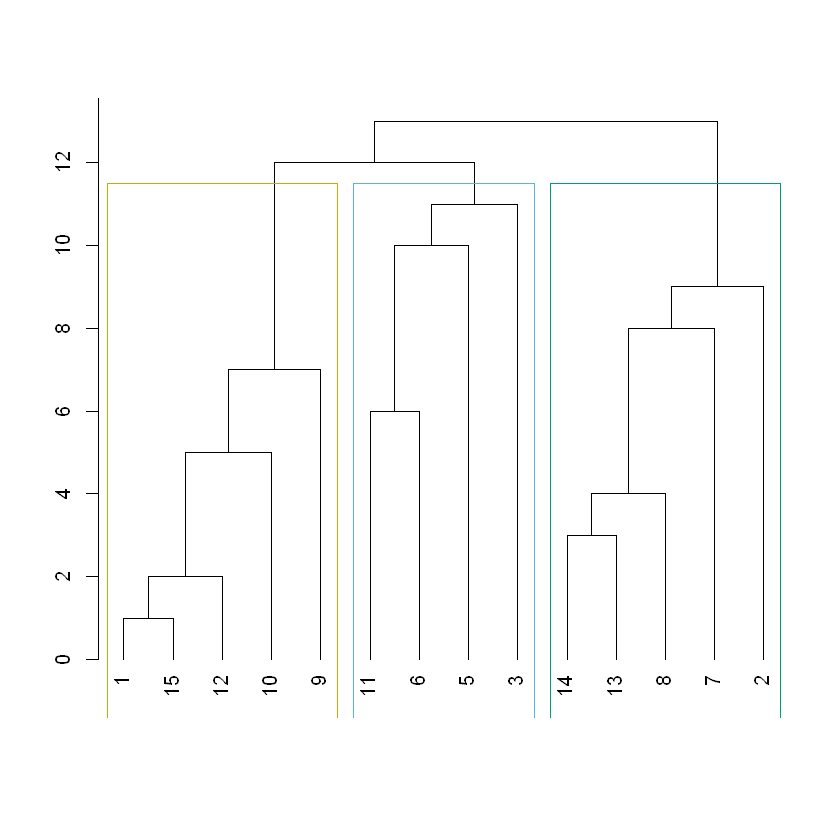

In [50]:
plot_dendrogram(friend_comm_eb)

Modularity is used as the criterion for determining the number of 
communities based on the dendrogram structure; namely modularity 
scores of the partitions at each level of the dendrogram are 
compared and the partition that results in the highest modularity 
score is selected. 
Let's get the modularity of the best partition and store it in 
our modularity_scores list

In [51]:
modularity_scores$EB <- modularity(friend_comm_eb)

Function animate_edge_betweenness() produces an animation of the EB
community detection process applied to the given graph (g). 
The function is defined in the 'SNA_custom_functions.R' script.
To run it, you may need to install ImageMagick:
http://www.imagemagick.org/script/binary-releases.php
The result is a .gif file that will be saved under the name specified
as the 2nd argument of the function.

In [52]:
#setwd("SNA_Labs")
source('SNA_custom_functions.R')
animate_edge_betweenness(friend_net_und, 'friend_net_eb.gif')

Output at: friend_net_eb.gif



[1] TRUE

Here we will integrate the output .gif file in the notebook to be able to see it here (rather than in the local folder):
<img src="friend_net_eb.gif" width="500" align="left">

#### 3B. COMMUNITY DETECTION: THE LOUVAINE METHOD 

The Louvaine community detection method is a hierarchical, bottom-up process, 
based on modularity. It brief, it works as follows:
- Initially, each vertex is assigned to a community on its own. 
- In every step, vertices are re-assigned to communities as follows: 
  - Each community is considered as a vertex on its own;
  - Each vertex is moved to the community with which it achieves the highest 
    contribution to modularity; 
  - When no vertices can be reassigned, so that the reassignment further 
    maximizes modularity, each community is considered a vertex, and the
    process starts again with the merged communities (as new vertices). 
- The process stops when there is only a single vertex left or when the 
  modularity cannot be increased any more in a step.
In a comprehensive comparative analysis of community detection algorithms 
(Lancichinetti & Fortunato, 2009), this algorith proved to be the second 
best algorithm (after InfoMap).

In [ ]:
?cluster_louvain

In [53]:
friend_comm_louvain <- cluster_louvain(friend_net_und)
friend_comm_louvain

IGRAPH clustering multi level, groups: 2, mod: 0.27
+ groups:
  $`1`
  [1] "3"  "5"  "6"  "9"  "10" "11" "12" "15" "1" 
  
  $`2`
  [1] "2"  "7"  "8"  "13" "14"
  

now, we got two groups: one w/ 5, the other with 9 vertices

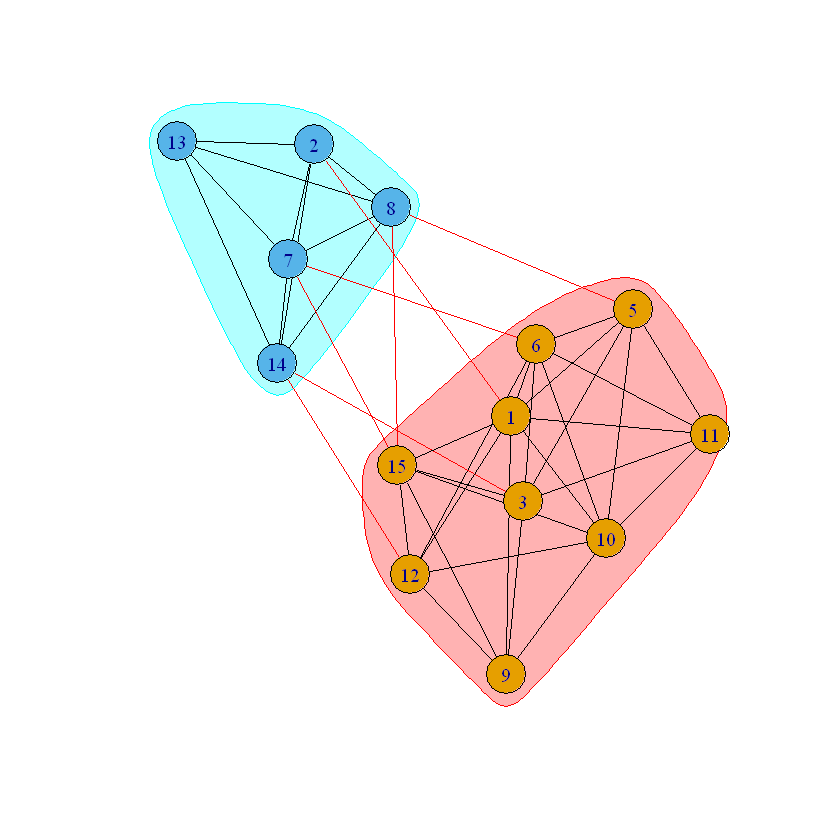

In [54]:
plot(friend_comm_louvain, friend_net_und)

We can also plot the detected communities without shaded regions, using 
node color to mark community membership and edge color to differentiate 
edges within and between communities

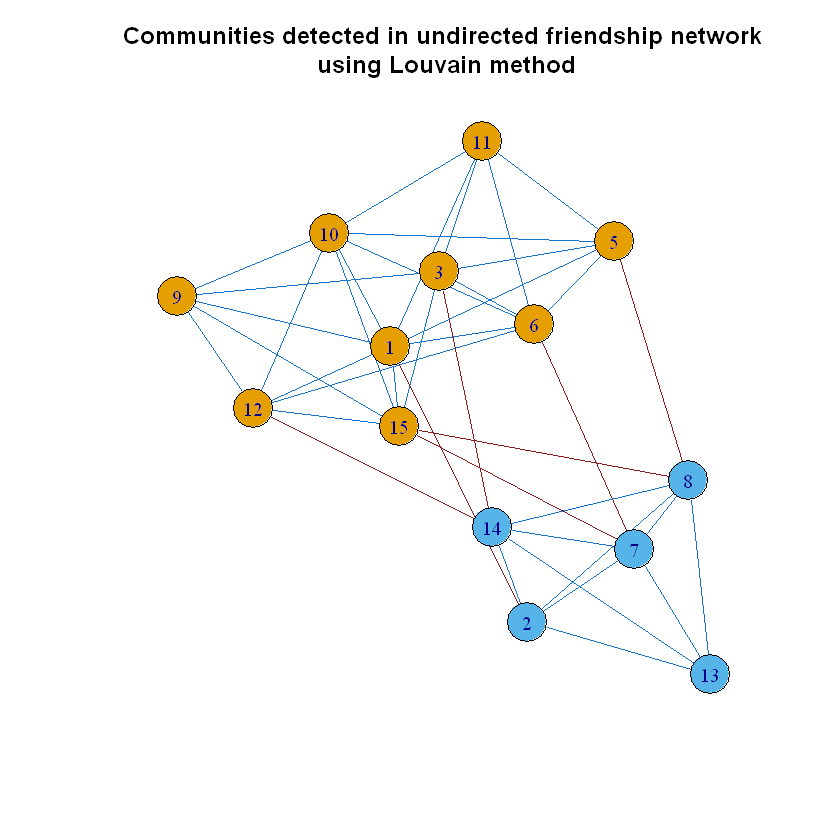

In [55]:
cross_community_edges <- which(crossing(friend_comm_louvain, friend_net_und))
edge_colors <- rep('dodgerblue3', times=ecount(friend_net_und))
edge_colors[cross_community_edges] <- 'firebrick4'
plot(friend_net_und, 
     layout=layout_with_fr(friend_net_und),
     vertex.color=membership(friend_comm_louvain),
     edge.color = edge_colors,
     main="Communities detected in undirected friendship network\n using Louvain method")

Retrieve the modularity score and add it to the modularity_scores list

In [56]:
modularity_scores$Louvain <- modularity(friend_comm_louvain)

We can also examine the communities that would be obtained if edge weights are
considered, that is, used by the Louvain algorithm

In [57]:
friend_comm_Louvain_w <- cluster_louvain(friend_net_und,
                                         weights = E(friend_net_und)$friend_tie)
friend_comm_Louvain_w

IGRAPH clustering multi level, groups: 3, mod: 0.33
+ groups:
  $`1`
  [1] "3"  "5"  "6"  "11"
  
  $`2`
  [1] "9"  "10" "12" "15" "1" 
  
  $`3`
  [1] "2"  "7"  "8"  "13" "14"
  

with weights considered, we get 3 communities

Let's plot it

In [58]:
cross_community_weighted <- crossing(friend_comm_Louvain_w, friend_net_und)
cross_community_weighted <- as.integer(cross_community_weighted)
edge_colors <- c('dodgerblue3', 'firebrick4')[cross_community_weighted + 1]

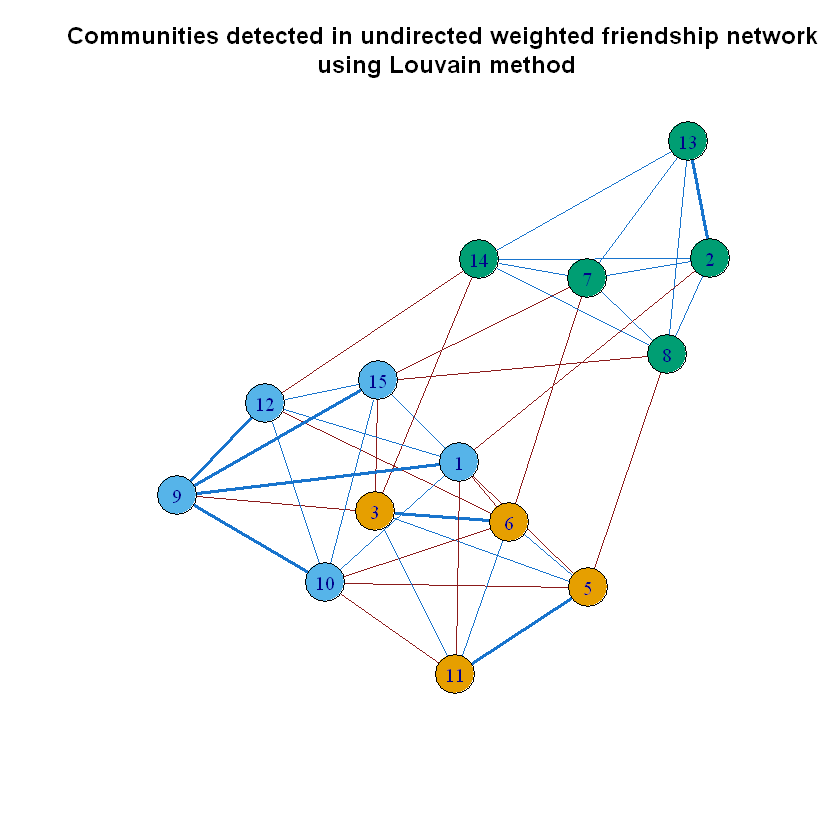

In [59]:
plot(friend_net_und, 
     layout = layout_with_fr(friend_net_und),
     vertex.color = membership(friend_comm_Louvain_w), 
     edge.color = edge_colors,
     edge.width = E(friend_net_und)$friend_tie * 1.5,
     main="Communities detected in undirected weighted friendship network\n using Louvain method")

Add modularity of the weighted result the modularity_scores list

In [60]:
modularity_scores$Louvain_weighted <- modularity(friend_comm_Louvain_w)

#### 3C. COMMUNITY DETECTION: WALKTRAP

This algorithm detects communities in a bottom-up manner, through 
a series of short random walks through the graph. 
The idea is that the vertices encountered on any given random walk 
are more likely to be within a community than not, since there are 
typically only a few edges that lead outside a given community. 

In brief, the algorithm works as follows:
Initially, it treats all nodes as communities of their own, then 
it iteratively merges them into larger communities, and these into 
still larger communities, and so on. In particular, in each iteration, 
walktrap runs short random walks and uses the results of these random walks 
to merge separate communities in a bottom-up manner. 

The Walktrap algorithm requires from the user to specify the length 
of random walks. Some researchers recommend walks of 4 or 5 steps, whereas
others question the quality of thus obtained communities.
A typical approach to estimating the quality of a particular graph 
partitioning (i.e. a particular way of splitting the graph into communities) 
is to compute the modularity score for the partitioning. The partitioning 
that maximizes the modularity score is considered the best; such result is
often referred to as the “maximum modularity partition”.

Since the walktrap algorithm is based on random walks, we need to set 
the seed to be able to replicate the results

In [61]:
set.seed(seed)
friend_comm_wt <- cluster_walktrap(friend_net_und, steps=4)
friend_comm_wt

IGRAPH clustering walktrap, groups: 2, mod: 0.27
+ groups:
  $`1`
  [1] "2"  "7"  "8"  "13" "14"
  
  $`2`
  [1] "3"  "5"  "6"  "9"  "10" "11" "12" "15" "1" 
  

we got two groups: one w/ 5, the other w/ 9 vertices

Plot the community structure

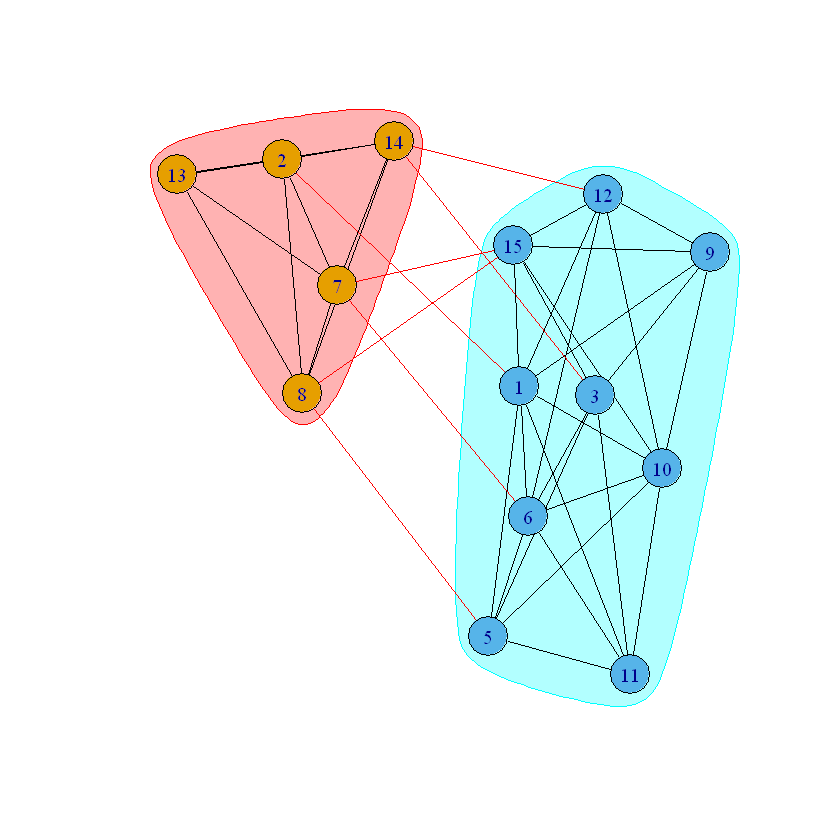

In [62]:
plot(friend_comm_wt, friend_net_und)

It seems that we got the same result as with the Louvain algorithm.
Let's verify that:

In [63]:
communities(friend_comm_louvain)
communities(friend_comm_wt)

$`1`
[1] "3"  "5"  "6"  "9"  "10" "11" "12" "15" "1" 

$`2`
[1] "2"  "7"  "8"  "13" "14"

$`1`
[1] "2"  "7"  "8"  "13" "14"

$`2`
[1] "3"  "5"  "6"  "9"  "10" "11" "12" "15" "1"

yes, they are equal


Get the modularity score and add it to the modularity_scores list

In [64]:
modularity_scores$WT_4steps <- modularity(friend_comm_wt)

We used 4 as the number of random steps, since that number of steps 
was reported as giving good results in many examined cases (networks).
If we want to more systematically determine the number of steps, we can
choose a range of values for the number of steps, execute the algorithm
for each value and eventually choose the one that results in the largest 
modularity value.

In [65]:
wt_modularity <- list()
for (s in 2:8) {
  set.seed(seed)
  wt_result <- cluster_walktrap(friend_net_und, steps = s)
  wt_modularity[[paste0('s=',s)]] <- modularity(wt_result)
}
max_wt_modularity <- max(unlist(wt_modularity))
wt_modularity[wt_modularity == max_wt_modularity]

$`s=2`
[1] 0.2797619

$`s=3`
[1] 0.2797619

We got the best score for 2 and 3 steps
So, let's re-run the algorithm with, e.g., 3 steps

IGRAPH clustering walktrap, groups: 3, mod: 0.28
+ groups:
  $`1`
  [1] "2"  "7"  "8"  "13" "14"
  
  $`2`
  [1] "9"  "10" "12" "15" "1" 
  
  $`3`
  [1] "3"  "5"  "6"  "11"
  

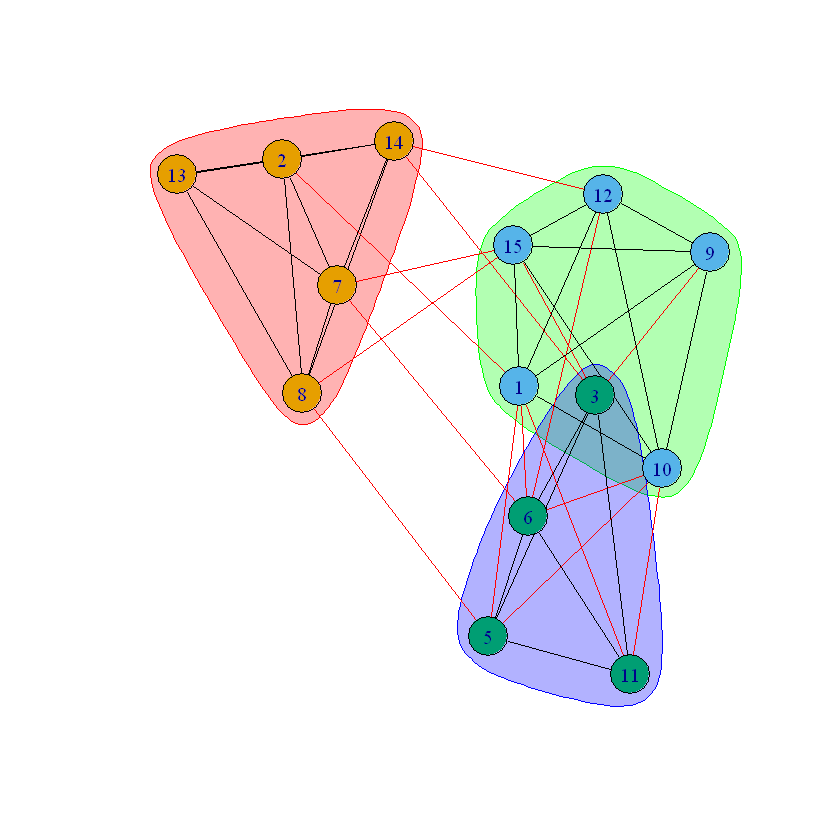

In [66]:
set.seed(seed)
friend_comm_wt_st3 <- cluster_walktrap(friend_net_und, steps=3)
friend_comm_wt_st3
plot(friend_comm_wt_st3, friend_net_und)

Now, we have 3 communities, as we got with the edge betweenness algorithm.

Add the modularity score for this solution to our modularity_scores list

In [67]:
modularity_scores$WT_3steps <- modularity(friend_comm_wt_st3)

We can also apply the walktrap algorithm with edge weights included.
To that end, we will repeat the above modularity-based process of finding 
the optimal number of steps in the random walk.

In [68]:
wt_weighted_modularity <- list()
for (s in 2:8) {
  set.seed(seed)
  wt_weighted_result <- cluster_walktrap(friend_net_und, steps = s, 
                                         weights = E(friend_net_und)$friend_tie)
  wt_weighted_modularity[[paste0('s=',s)]] <- modularity(wt_weighted_result)
}
max_mod_wt_weighted <- max(unlist(wt_weighted_modularity))
wt_weighted_modularity[wt_weighted_modularity == max_mod_wt_weighted]

$`s=2`
[1] 0.3292378

$`s=3`
[1] 0.3292378

Again, we got the best score for 2 and 3 steps
Let's re-run the algorithm again with 3 steps

In [69]:
set.seed(seed)
friend_comm_wt_weighted <- cluster_walktrap(friend_net_und, steps=3,
                                            weights = E(friend_net_und)$friend_tie)
friend_comm_wt_weighted

IGRAPH clustering walktrap, groups: 3, mod: 0.33
+ groups:
  $`1`
  [1] "2"  "7"  "8"  "13" "14"
  
  $`2`
  [1] "9"  "10" "12" "15" "1" 
  
  $`3`
  [1] "3"  "5"  "6"  "11"
  

Plot the result using a custom color scheme

In [70]:
weighted_fr_layout <- layout_with_fr(friend_net_und, 
                                     weights = E(friend_net_und)$friend_tie)

In [71]:
cross_community_edges <- crossing(friend_comm_wt_weighted, friend_net_und)
edge_colors <- c('midnightblue', 'firebrick4')[cross_community_edges + 1]

In [72]:
node_colors <- c('orangered2', 'limegreen', 'gold')[membership(friend_comm_wt_weighted)]

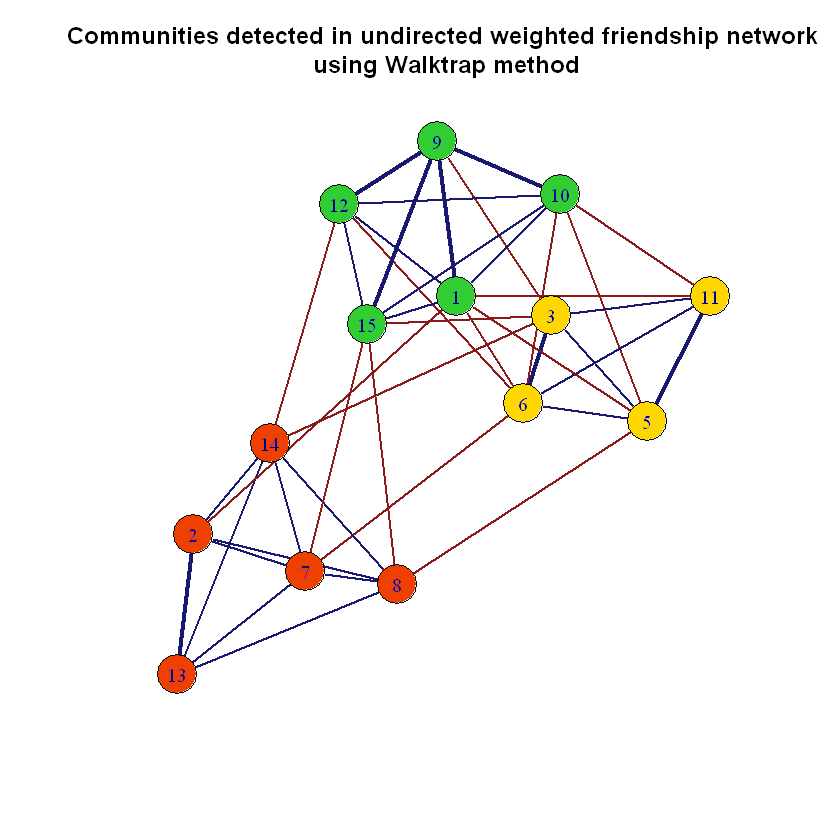

In [73]:
plot(friend_net_und,
     layout = weighted_fr_layout,
     vertex.color = node_colors,
     edge.width = E(friend_net_und)$friend_tie * 1.75,
     edge.color = edge_colors,
     main="Communities detected in undirected weighted friendship network\n using Walktrap method") 

Add the modularity score for this solution to our modularity_scores list

In [74]:
modularity_scores$WT_weighted <- modularity(friend_comm_wt_weighted)

#### 3D. AGGLOMERATIVE HIERARCHICAL CLUSTERING (UNDIRECTED, WEIGHTED GRAPH)

We will now apply hierarchical clustering as a general clustering method, 
that is, a method that is not specifically designed for community 
detection in social networks but can be applied in various domains

Step 1: get the adjacency matrix of the undirected friendship graph

In [75]:
friend_und_adj_mat <- as_adjacency_matrix(friend_net_und, 
                                         attr = 'friend_tie',
                                         sparse=FALSE)
friend_und_adj_mat

,2,3,5,6,7,8,9,10,11,12,13,14,15,1
2,0,0,0,0,1,1,0,0,0,0,2,1,0,1
3,0,0,1,2,0,0,1,0,1,0,0,1,1,0
5,0,1,0,1,0,1,0,1,2,0,0,0,0,1
6,0,2,1,0,1,0,0,1,1,1,0,0,0,1
7,1,0,0,1,0,1,0,0,0,0,1,1,1,0
8,1,0,1,0,1,0,0,0,0,0,1,1,1,0
9,0,1,0,0,0,0,0,2,0,2,0,0,2,2
10,0,0,1,1,0,0,2,0,1,1,0,0,1,1
11,0,1,2,1,0,0,0,1,0,0,0,0,0,1
12,0,0,0,1,0,0,2,1,0,0,0,1,1,1


Step 2: compute cosine similarity between rows of the adjacency matrix

Note: cosine similarity is a frequently used measure for estimating 
similarity of numeric vectors. Other typically used similarity / distance
measures include: Euclidean distance, Manhattan distance, and 
Pearson correlation coefficient.

To compute cosine similarity, we will use the simil() function
from the *proxy* R package:

In [76]:
friend_und_cos_sim <- simil(friend_und_adj_mat, method = "cosine")

set 1 on the diagonal as that is the maximum Cosine similarity value

In [77]:
friend_und_sim_mat <- as.matrix(friend_und_cos_sim, diag=1)
#View(friend_und_sim_mat)
friend_und_sim_mat

,2,3,5,6,7,8,9,10,11,12,13,14,15,1
2,1.0000000,0.1178511,0.2357023,0.2236068,0.5773503,0.5773503,0.1714986,0.1118034,0.1250000,0.2357023,0.4008919,0.5773503,0.3354102,0.0000000
3,0.1178511,1.0000000,0.4444444,0.2108185,0.5443311,0.4082483,0.1616904,0.7378648,0.4714045,0.6666667,0.1259882,0.0000000,0.2108185,0.7035265
5,0.2357023,0.4444444,1.0000000,0.6324555,0.2721655,0.0000000,0.4042260,0.4216370,0.4714045,0.3333333,0.1259882,0.2721655,0.4216370,0.4020151
6,0.2236068,0.2108185,0.6324555,1.0000000,0.0000000,0.2581989,0.6135720,0.4000000,0.6708204,0.2108185,0.1195229,0.5163978,0.6000000,0.3813850
7,0.5773503,0.5443311,0.2721655,0.0000000,1.0000000,0.6666667,0.1980295,0.2581989,0.1443376,0.4082483,0.6172134,0.5000000,0.1290994,0.3692745
8,0.5773503,0.4082483,0.0000000,0.2581989,0.6666667,1.0000000,0.1980295,0.2581989,0.2886751,0.2721655,0.6172134,0.5000000,0.1290994,0.3692745
9,0.1714986,0.1616904,0.4042260,0.6135720,0.1980295,0.1980295,1.0000000,0.4601790,0.4287465,0.4850713,0.0000000,0.2970443,0.5368755,0.4387635
10,0.1118034,0.7378648,0.4216370,0.4000000,0.2581989,0.2581989,0.4601790,1.0000000,0.4472136,0.7378648,0.0000000,0.1290994,0.6000000,0.8581163
11,0.1250000,0.4714045,0.4714045,0.6708204,0.1443376,0.2886751,0.4287465,0.4472136,1.0000000,0.3535534,0.0000000,0.1443376,0.3354102,0.4264014
12,0.2357023,0.6666667,0.3333333,0.2108185,0.4082483,0.2721655,0.4850713,0.7378648,0.3535534,1.0000000,0.1259882,0.0000000,0.6324555,0.7035265


We can use corrplot to get an idea about the grouping of nodes
(based on the similarity of their network connections) 

corrplot 0.84 loaded



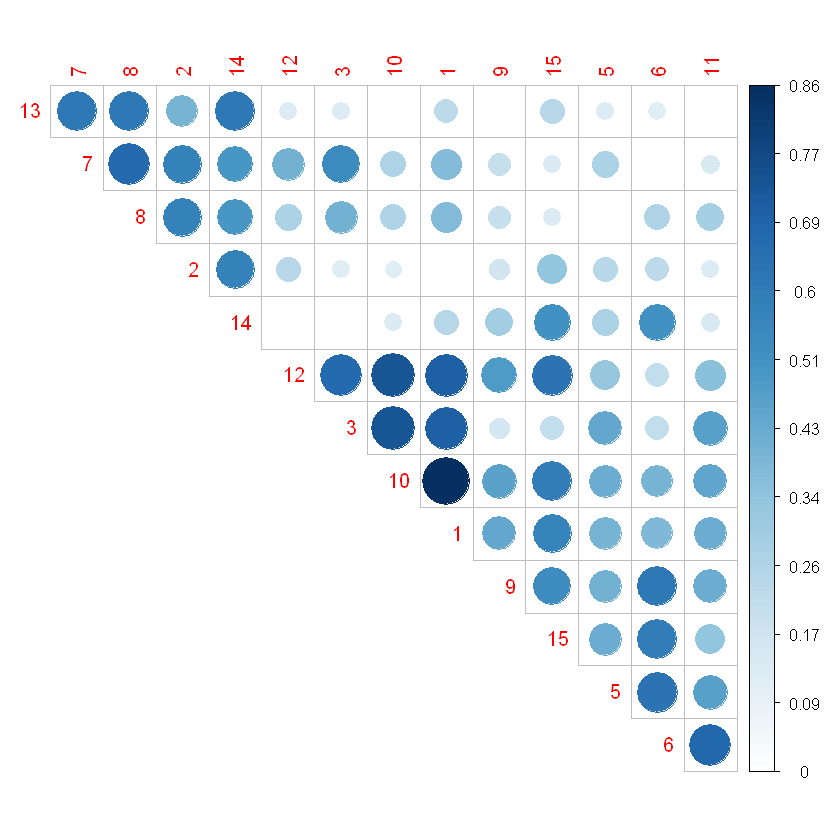

In [78]:
library(corrplot)
corrplot(friend_und_sim_mat, is.corr = FALSE, type = 'upper', 
         diag = FALSE, order = 'hclust')

Step 3: create distance matrix, required by the clustering function

In [79]:
friend_und_dist_mat <- 1-friend_und_sim_mat

Step 4: do the clustering using the hclust function

In [92]:
?hclust

The function offers different linkage methods, among which 'ward.D2' 
and 'complete' linkage are often used

In [80]:
friend_und_hc <- hclust(as.dist(friend_und_dist_mat), 
                        method = "ward.D2")

Step 5: plot dendrogram

In [84]:
#install.packages('factoextra')

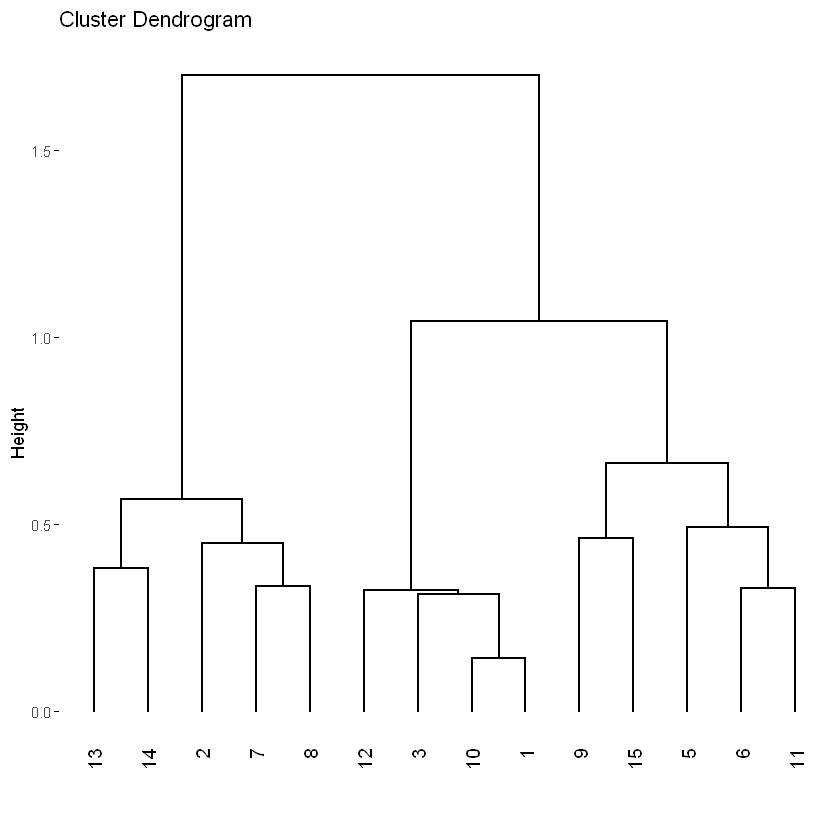

In [86]:
library(factoextra)
fviz_dend(friend_und_hc)

Note: previous step (plotting using function ```fviz_dend```) might not work properly on R version 3.6. It is not an essential step, and you can continue without this visualisation, but for full reproduction of figures, R version 4.0 everything should work smoothly.

Step 6: Choose the best number of clusters by examining the structure 
of the dendrogram and using modularity to choose between the candidate 
solutions.

2 clusters:

In [87]:
modularity(friend_net_und, cutree(friend_und_hc, k = 2))

[1] 0.2695578

3 clusters:

In [88]:
modularity(friend_net_und, cutree(friend_und_hc, k = 3))

[1] 0.07057823

Based on the modularity scores, 2 clusters is far better option.
Color the clusters to better visualise them

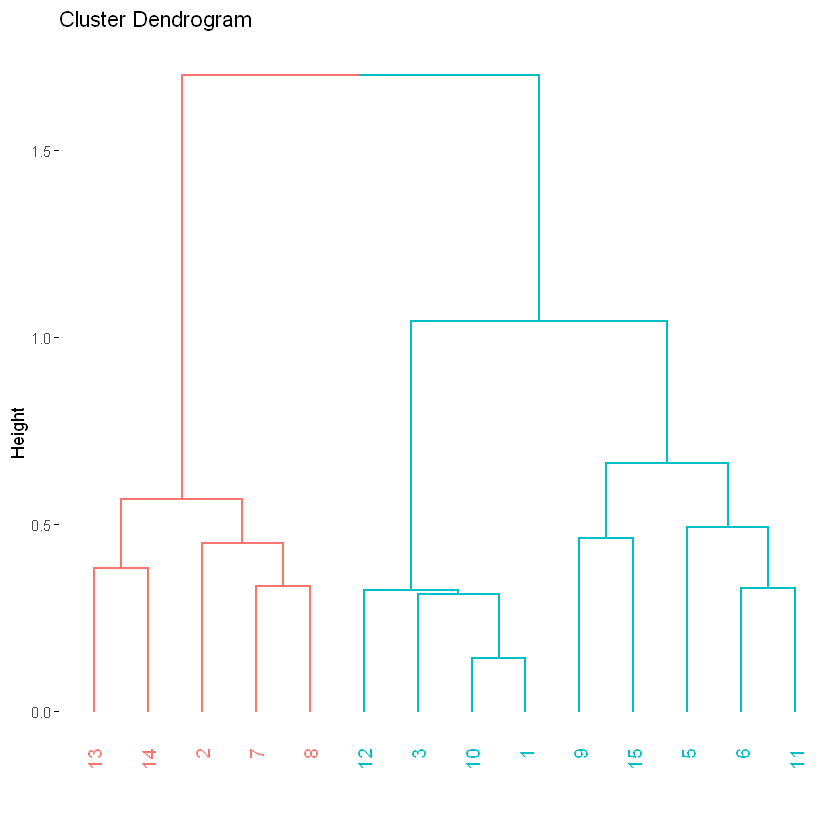

In [89]:
fviz_dend(friend_und_hc, k=2)

Step 7: get cluster assignments by cutting the dendrogram into 2 clusters

In [90]:
friend_und_clust <- cutree(friend_und_hc, k = 2)

Plot graph with clusters

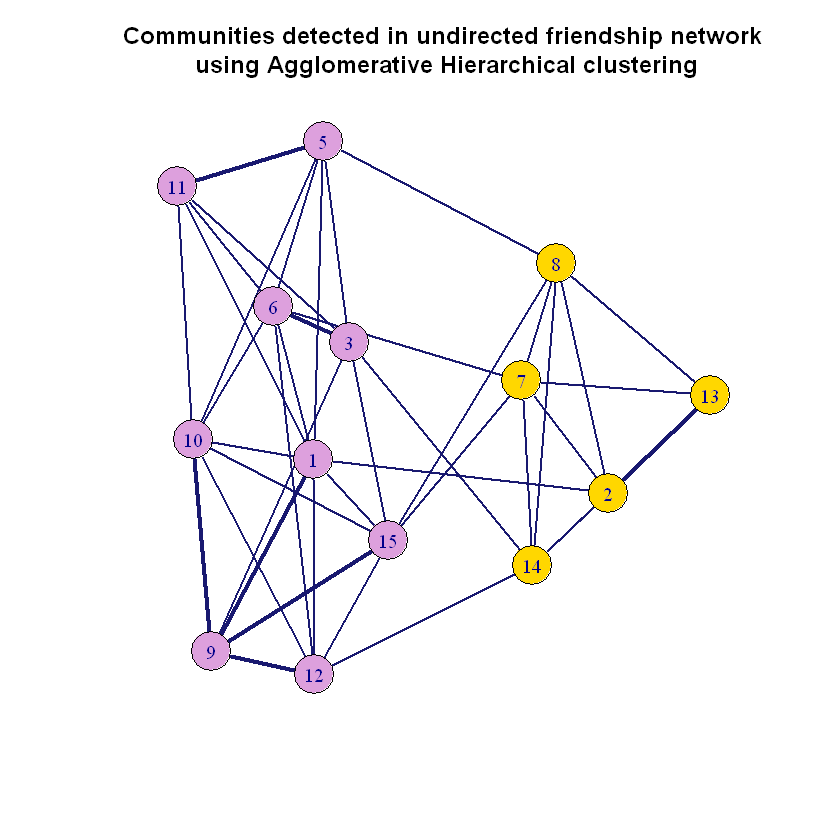

In [91]:
plot(friend_net_und, 
     vertex.color=c('gold', 'plum')[friend_und_clust], 
     layout = layout_with_fr(friend_net_und),
     edge.color = 'midnightblue',
     edge.width = E(friend_net_und)$friend_tie * 1.75,
     main="Communities detected in undirected friendship network\n using Agglomerative Hierarchical clustering")

Add modularity to the modularity_scores list

In [92]:
modularity_scores$HC <- modularity(friend_net_und, friend_und_clust)

#### 3E. AGGLOMERATIVE HIERARCHICAL CLUSTERING (DIRECTED, WEIGHTED GRAPH)

We will now apply hierarchical clustering but using directed
(and weighted) friendship graph

Step 1: get the graph's adjacency matrix

In [93]:
friend_net_adj_mat = as_adjacency_matrix(friend_net, 
                                         sparse=FALSE, 
                                         attr = 'friend_tie')
friend_net_adj_mat

,2,3,5,6,7,8,9,10,11,12,13,14,15,1
2,0,0,0,0,1,1,0,0,0,0,2,1,0,1
3,0,0,1,1,0,0,0,0,1,0,0,1,1,0
5,0,1,0,1,0,1,0,1,2,0,0,0,0,1
6,0,2,1,0,1,0,0,1,1,1,0,0,0,1
7,1,0,0,0,0,1,0,0,0,0,1,1,0,0
8,1,0,1,0,1,0,0,0,0,0,1,1,1,0
9,0,1,0,0,0,0,0,2,0,2,0,0,2,2
10,0,0,0,0,0,0,1,0,0,1,0,0,1,1
11,0,1,1,1,0,0,0,1,0,0,0,0,0,1
12,0,0,0,0,0,0,1,0,0,0,0,0,1,1


Step 2: compute cosine similarity between nodes based on
both incoming and outgoing connections
Note: since simil() f. computes similarity between vectors 
in rows of the given matrix, to compute:
- similarity based on outgoing connections, we can use the matrix 
  directly (as is) 
- similarity based on incoming connections, we need to transpose 
  the adj. matrix before using it as input for the simil f. 

In [94]:
friend_net_out_sim <- as.matrix(simil(friend_net_adj_mat, method = 'cosine'), diag=1)
friend_net_in_sim <- as.matrix(simil(t(friend_net_adj_mat), method = 'cosine'), diag=1)

Combine the two similarity matrices by averaging them
(other options - sum, prod, min, max - are also possible)

In [95]:
friend_net_sim_mat <- (friend_net_in_sim + friend_net_out_sim)/2

Step 3: create distance matrix, required by the clustering function

In [96]:
friend_net_dist_mat <- 1 - friend_net_sim_mat

Step 4: use the hclust f. to do the clustering

In [97]:
friend_net_hc <- hclust(as.dist(friend_net_dist_mat), method = "ward.D2")

Step 5: plot the dendrogram

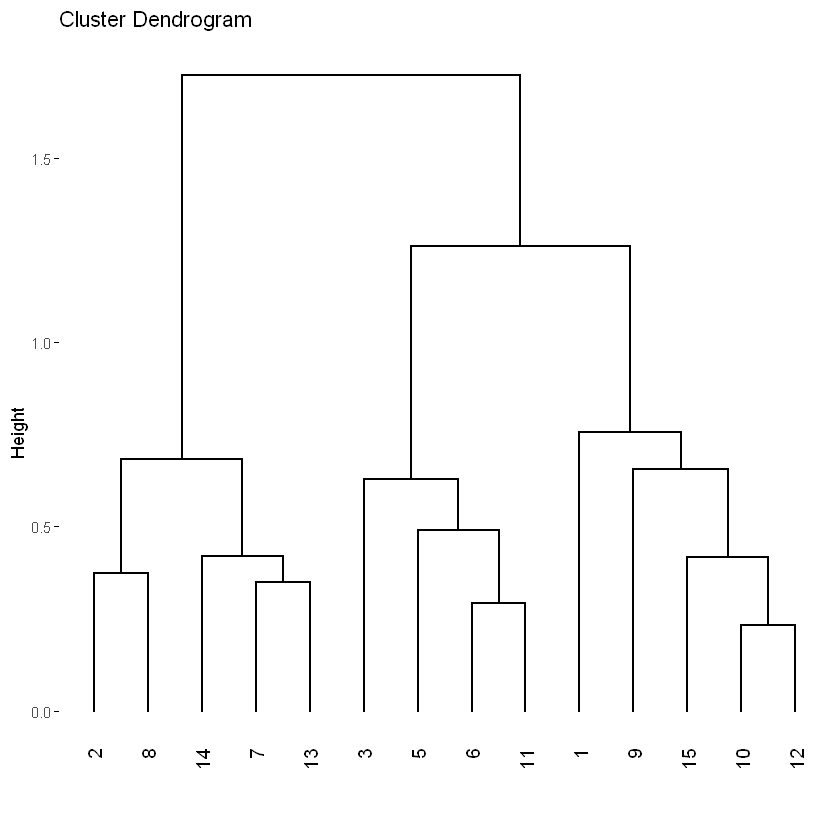

In [98]:
fviz_dend(friend_net_hc)

Step 6: Choose the best number of clusters by examining the structure 
of the dendrogram and modularity of the candidate solutions 
Note: the modularity() function will disregard the direction of edges

2 clusters:

In [99]:
modularity(friend_net, cutree(friend_net_hc, k = 2))

[1] 0.3172477

3 clusters:

In [100]:
modularity(friend_net, cutree(friend_net_hc, k = 3))

[1] 0.3747399

Based on the modularity scores, 3 clusters is the better option. 
Use colors to visualise clusters

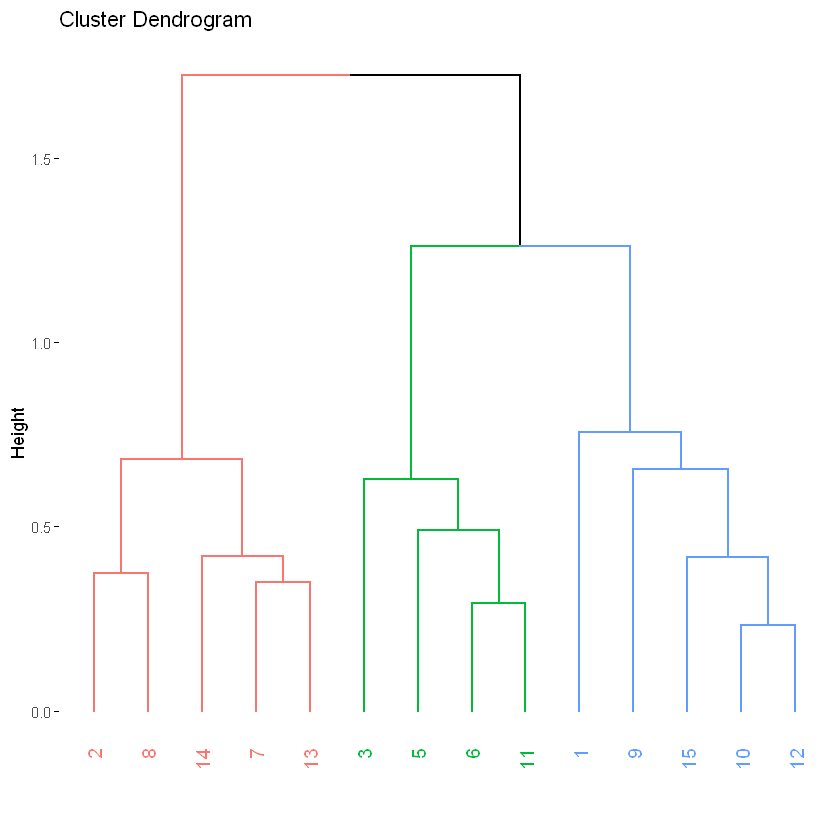

In [101]:
fviz_dend(friend_net_hc, k = 3)

Step 7: get cluster assignments by cutting the dendrogram into 3 clusters

In [102]:
friend_net_clust = cutree(friend_net_hc, k = 3)

Plot graph with clusters

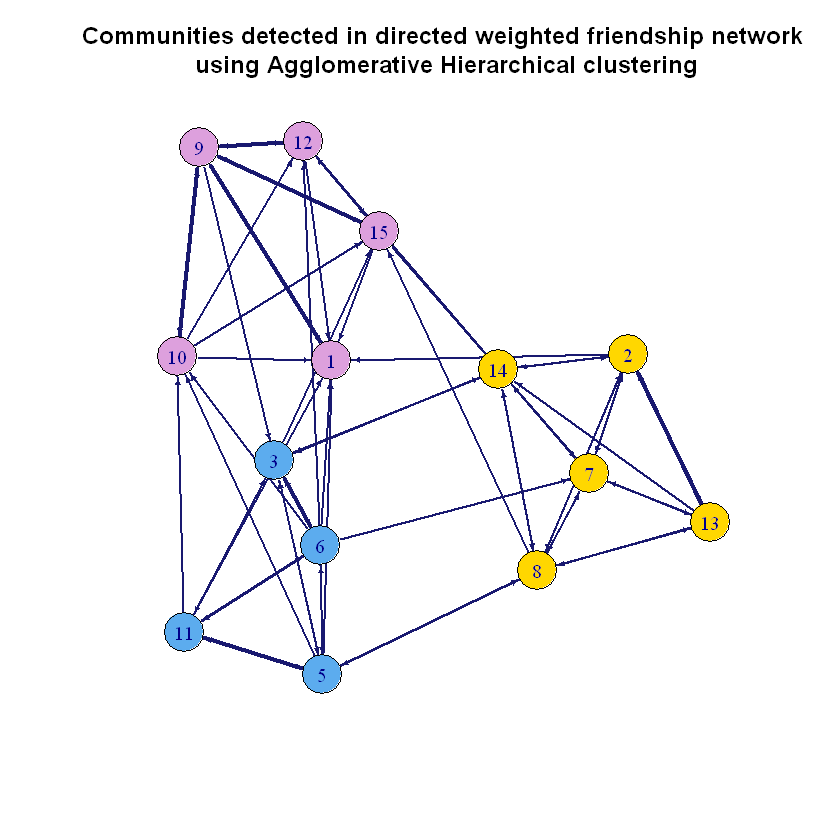

In [103]:
plot(friend_net, 
     vertex.color=c('gold', 'steelblue2', 'plum')[friend_net_clust], 
     edge.width = E(friend_net)$friend_tie * 1.75,
     edge.color = 'midnightblue',
     edge.arrow.size = 0.3,
     main="Communities detected in directed weighted friendship network\n using Agglomerative Hierarchical clustering")

Add modularity to the modularity_scores list

In [104]:
modularity_scores$HC_weighted <- modularity(friend_net, friend_net_clust)

#### 3F. EDGE BETWEENNESS (EB) APPLIED TO DIRECTED GRAPHS 

The EB community detection method is one of few that can be applied to directed graphs
(though the implementation is far from perfect as you'll see in the warning messages).
It also allows for the inclusion of edge weights. Here, it is important to note that
"edges are interpreted as distances, not as connection strengths"

In [105]:
?cluster_edge_betweenness

In [106]:
friend_dir_eb <- cluster_edge_betweenness(friend_net, 
                                           directed = TRUE,
                                           weights = 1/E(friend_net)$friend_tie)
friend_dir_eb

Warning message in cluster_edge_betweenness(friend_net, directed = TRUE, weights = 1/E(friend_net)$friend_tie):
"At community.c:460 :Membership vector will be selected based on the lowest modularity score."
Warning message in cluster_edge_betweenness(friend_net, directed = TRUE, weights = 1/E(friend_net)$friend_tie):
"At community.c:467 :Modularity calculation with weighted edge betweenness community detection might not make sense -- modularity treats edge weights as similarities while edge betwenness treats them as distances"


IGRAPH clustering edge betweenness, groups: 2, mod: 0.31
+ groups:
  $`1`
  [1] "2"  "7"  "8"  "13" "14"
  
  $`2`
  [1] "3"  "5"  "6"  "9"  "10" "11" "12" "15" "1" 
  

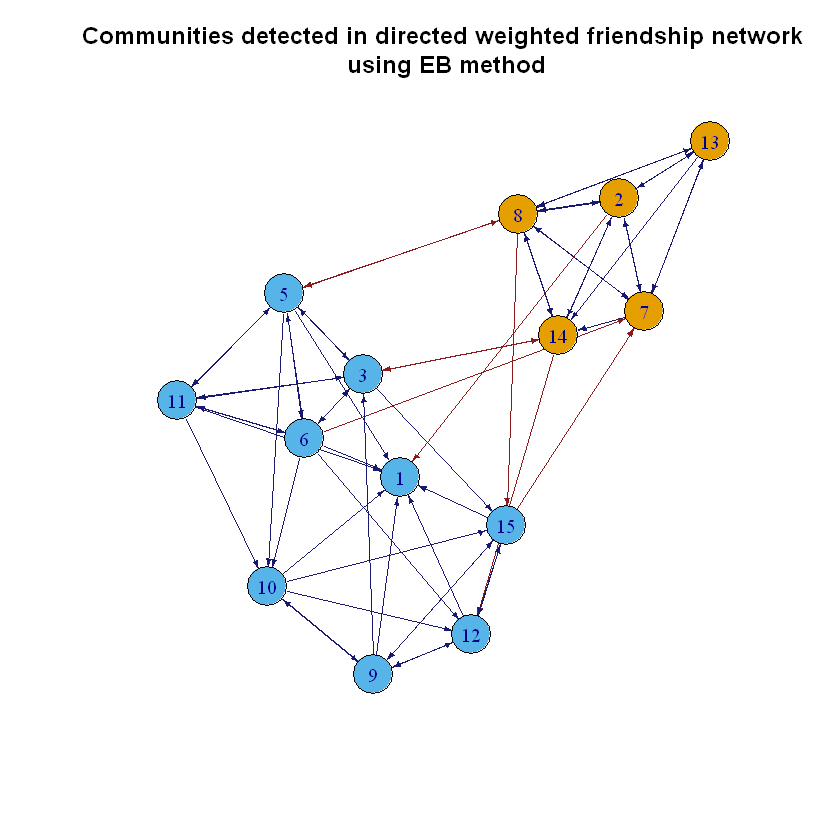

In [107]:
cross_community_edges <- crossing(friend_dir_eb, friend_net)
edge_colors <- c('midnightblue', 'firebrick4')[cross_community_edges + 1]
plot(friend_net, 
     layout=layout_with_fr(friend_net),
     vertex.color=membership(friend_dir_eb),
     edge.color = edge_colors,
     edge.arrow.size = 0.3,
     main="Communities detected in directed weighted friendship network\n using EB method")

In [108]:
modularity_scores$EB_dir_wt <- modularity(friend_dir_eb)

#### 3G. COMPARE THE PERFORMANCE OF THE USED COMMUNITY DETECTION ALGORITHMS 

Let's examine the collected modularity scores:

In [109]:
modularity_scores

$EB
[1] 0.2797619

$Louvain
[1] 0.2695578

$Louvain_weighted
[1] 0.3292378

$WT_4steps
[1] 0.2695578

$WT_3steps
[1] 0.2797619

$WT_weighted
[1] 0.3292378

$HC
[1] 0.2695578

$HC_weighted
[1] 0.3747399

$EB_dir_wt
[1] 0.3113853

Based on the modularity scores, for the undirected graph, the best solutions 
are those generated by the Louvain and Walktrap algorithms

In [110]:
friend_comm_Louvain_w
friend_comm_wt_weighted

IGRAPH clustering multi level, groups: 3, mod: 0.33
+ groups:
  $`1`
  [1] "3"  "5"  "6"  "11"
  
  $`2`
  [1] "9"  "10" "12" "15" "1" 
  
  $`3`
  [1] "2"  "7"  "8"  "13" "14"
  

IGRAPH clustering walktrap, groups: 3, mod: 0.33
+ groups:
  $`1`
  [1] "2"  "7"  "8"  "13" "14"
  
  $`2`
  [1] "9"  "10" "12" "15" "1" 
  
  $`3`
  [1] "3"  "5"  "6"  "11"
  

For directed graph, the best result was obtained with the hierarchical clustering

In [111]:
friend_net_clust

2  3  5  6  7  8  9 10 11 12 13 14 15  1 
 1  2  2  2  1  1  3  3  2  3  1  1  3  3

as all three algorithms lead to the same communities, we can assume that it is the
the best community structure for the given (friendship) network

### TASK: 
identify communities - using the above examined community detection algorithms - 
in at least one of the other two networks: social_net and task_net.
